In [1]:
import os, time
import numpy as np
import pickle
from copy import deepcopy
from sklearn.decomposition import PCA
from tqdm import tqdm

# Pytorch
import torch
use_cuda = False
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from rnn_model_dt import RNN_Net
from task_generators import cycling as gen_task

Use cpu.


In [2]:
file_name = "neuro_noise_compression.pkl"
data_file = os.path.join(data_path, file_name)
with open(data_file, 'rb') as handle:
    res = pickle.load(handle)
    [
    task_names, task_lbls, n_task, lbl_sce, dim_hid,
    n_samples, n_sce, n_mi, 
    n_tc, n_samp_per_tc,batch_size_ex, n_comp_tca, n_rps, n_ops, n_pps, var_rps, var_ops, var_pps, 
    t_pc_min,
    ] = res
    del res
print('Load from ', data_file)

# Only networks initialized with g > 1.
sce_plt = [3, 1]
n_sce_plt = len(sce_plt)

Load from  ../data/neuro_noise_compression.pkl


### Example cycling task

In [3]:
file_name = "cycling_n_256_train_rec_only.pkl"
data_file = os.path.join(data_path, file_name)
sce_plt_ex = np.array([1, 0])
n_sce_plt_ex = len(sce_plt_ex)
with open(data_file, 'rb') as handle:
    res = pickle.load(handle)
    [
        n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
        dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
        gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
        task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
        loss_all, output_all, hids_all, h_0_all, sd_if_all, 
        n_rec_steps, rec_step_width, rec_steps, loss_avg_all, 
        w_in_norm_all, w_rec_norm_all, w_out_norm_all,
        dw_out_norm_all, dw_rec_norm_all, 
        h_proj_all, ps_all,
    ] = res
    del res
    print('Loaded from ', data_file)
lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]
lbl_sce = ["Oblique", "Aligned"] if n_sce == 2 else ["Oblique", "Oblique", "Aligned", "Aligned"]
t_dec = task_params["t_dec"]
freq = task_params["freq"]

Loaded from  ../data/cycling_n_256_train_rec_only.pkl


In [4]:
# Test task for plotting, or others

# Parameters
noise_input_std_ex = noise_input_std
noise_init_std_ex = noise_init_std
noise_hid_std_ex = noise_hid_std
assert noise_input_std_ex == 0.
assert noise_init_std_ex == 1.
assert noise_hid_std_ex == 0.2

t_max_ex = 150
task_params_ex = deepcopy(task_params)
task_params_ex["t_max"] = t_max_ex
# task_params_ex["test"] = True
ts_ex, input_ex, target_ex, mask_ex = gen_task(dim_in, dim_out, dt, **task_params_ex)(batch_size)
noise_input_ex = noise_input_std_ex * np.float32(np.random.randn(*input_ex.shape)) / np.sqrt(dt)
noise_init_ex = noise_init_std_ex * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
task_ex = ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex
ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex = [to_dev(arr) for arr in task_ex]
n_t_ex = len(ts_ex)
output_ex = np.zeros((*n_mi, batch_size, n_t_ex, dim_out), dtype=np.float32)
hids_ex = torch.zeros((*n_mi, batch_size, n_t_ex, dim_hid))
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.load_state_dict(sd_if_all[1][mi])
    h_0 = h_0_all[mi]
    # Transfer
    net.to(device)
    h_0 = h_0.to(device)
    with torch.no_grad():
        output, hids = net.forward_hid(input_ex + noise_input_ex, 
                                       h_0 + noise_init_ex, 
                                       noise_hid_std_ex, last_time=False)
        output_ex[mi] = output.cpu()
        hids_ex[mi] = hids.cpu()[0]

In [5]:
task_pl = task_ex
hids_pl = hids_ex
output_pl = output_ex
n_t_pl = hids_pl.shape[-2]

n_pts = 2000
n_wps = 1000
var_rps_ex = np.zeros((*n_mi, n_pts))
var_ops_ex = np.zeros((*n_mi, n_wps))
var_pps_ex = np.zeros((*n_mi, n_wps))

# Obtain variance along projections for aligned and oblique
# Remove transients and late dynamics?
t_cov_min = t_pc_min
t_cov_max = t_dec
n_c_min = int(t_cov_min / (dt * rec_step_dt))
n_c_max = int(t_cov_max / (dt * rec_step_dt))
n_t_h = n_c_max - n_c_min

# Project the difference on the 1st PC and w_perp
n_proj = 2
dim_proj = 2
p_dh = torch.zeros((*n_mi, n_proj, batch_size, n_t_h, dim_proj))
wo_ps = torch.zeros((*n_mi, n_proj, dim_proj))

for mi in np.ndindex(*n_mi):
    w_out = sd_if_all[1][mi]['decoder.weight'].clone()

    h = hids_pl[mi][:, n_c_min:n_c_max]

    # For the cylcing task, trial types are split by even/odd batch numbers.
    n_ctx = 2
    # Trial conditioned average and fluctuations
    h_tca = torch.zeros((n_ctx, n_t_h, dim_hid))
    dh = torch.zeros((batch_size, n_t_h, dim_hid))
    for ctx in range(n_ctx):
        h_c = h[ctx::2]
        h_c_m = h_c.mean(axis=-3)
        h_tca[ctx] = h_c_m
        dh[ctx::2] = h_c - h_c_m
    # h_tca = h.clone()
    # dh = h.clone()
    h_tca = h_tca.reshape(-1, dim_hid)
    dh = dh.reshape((-1, dim_hid))

    # PCA of trial-cond. avg
    n_comp_tca = 2
    pca = PCA(n_comp_tca)
    pca.fit(h_tca)
    pcs_tca = torch.from_numpy(np.float32(pca.components_))

    # Compute variance along random and nonrandom directions
    # Random projections
    rps = torch.randn((n_pts, dim_hid))#, device=device)
    rps = rps / rps.norm(dim=1)[:, None]
    var_rps_ex[mi] = (dh @ rps.T).var(axis=0).cpu().numpy()
    # Variance along output directions
    w_mix = torch.randn((n_wps, dim_out)) @ torch.linalg.qr(w_out.T)[0].T
    w_mix /= torch.linalg.norm(w_mix, axis=-1, keepdims=True)
    var_ops_ex[mi] = (dh @ w_mix.T).var(axis=0).cpu().numpy()
    # Variance along the trial-condition averaged PCs
    w_mix = torch.randn((n_wps, n_comp_tca)) @ pcs_tca
    w_mix /= torch.linalg.norm(w_mix, axis=-1, keepdims=True)
    var_pps_ex[mi] = (dh @ w_mix.T).var(axis=0).cpu().numpy()

    # Project the difference on the 1st PC and w_perp
    for i_pr in range(n_proj):
        if i_pr == 0:
            pc_w = torch.linalg.qr(torch.concat([pcs_tca[:1], w_out[:1]]).T)[0].T
        else:
            v_rand = torch.randn(1, dim_hid)
            pc_w = torch.linalg.qr(torch.concat([v_rand, w_out[:1]]).T)[0].T
        # Fix signs
        for i_out in range(len(pc_w)):
            if w_out[0] @ pc_w[i_out] < 0:
                pc_w[i_out] *= -1
        p_dh[mi][i_pr] = dh.reshape(batch_size, n_t_h, dim_hid) @ pc_w.T
        wo_ps[mi][i_pr] = w_out[0] @ pc_w.T
    

In [6]:
# Plot variance projection
def plot_var_proj(axes):
    n_rows, n_cols = axes.shape
    for i_r, i_c in np.ndindex(n_rows, n_cols):
        ax = axes[i_r, i_c]
        i_sce = sce_plt_ex[i_r]
        mi = i_s, i_sce

        alpha=0.9
        # PCs
        dens_pcs, bins_pcs = np.histogram(var_pps_ex[mi], 10, density=False)
        ax.stairs(dens_pcs, bins_pcs, fill=True, color=colors[0], label="PCs", alpha=alpha)
        # Output
        dens_os, bins_os = np.histogram(var_ops_ex[mi], 10, density=False)
        ax.stairs(dens_os, bins_os, fill=True, color=colors[3], label="output", alpha=alpha, zorder=3)
        # Random projections
        dens, bins = np.histogram(var_rps_ex[mi], 100, density=False)
        ax.stairs(dens, bins, fill=True, linewidth=0, color='0.6', label=r"random", alpha=alpha)
        ylim = dens.max() * 1.1

        ax.set_xscale('log')
        xmax = var_pps_ex.max()
        xmin = min(var_rps_ex.min(), var_ops_ex.min())
        ax.set_xlim(xmin*0.8, xmax*1.2)

        ax.set_ylim(0, 120)
        ax.set_yticklabels([])

        ax.set_ylabel("Counts")

        if i_r == n_rows - 1:
            ax.set_xlabel("Variance along projection")
        else:
            ax.set_xticklabels([])

    # Polish
    ax = axes[0, 0]
    ax.legend(loc=1, ncol=1, 
        labelspacing=0.4, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
        frameon=True,
        bbox_to_anchor=(0.8, 1.07)
    )

In [7]:
# Plot ratio var along output / var along PC
def plot_ratio_var(ax):
    file_name = "neuro_noise_compression.pkl"
    data_file = os.path.join(data_path, file_name)
    with open(data_file, 'rb') as handle:
        res = pickle.load(handle)
        [
        task_names, task_lbls, n_task, lbl_sce, dim_hid,
        n_samples, n_sce, n_mi, 
        n_tc, n_samp_per_tc,batch_size_ex, n_comp_tca, n_rps, n_ops, n_pps, var_rps, var_ops, var_pps, 
        t_pc_min,
        ] = res
        del res
    # print('Load from ', data_file)

    # Ratio output var / PC var
    # ys = var_ops.mean(-1) / var_pps.mean(-1)
    # y_ex = var_ops_ex.mean(-1) / var_pps_ex.mean(-1)
    # Ratio output var / random var
    ys = var_ops.mean(-1) / var_rps.mean(-1)
    plot_stats(ax, ys, sce_plt, dx_fac=dx_fac)
    
    y_ex = var_ops_ex.mean(-1) / var_rps_ex.mean(-1)
        
    # Example in the other plots
    if n_sce_plt == 2:
        xs = np.arange(n_task)
        dxi = 0.7 / n_sce_plt
        # dxs = np.zeros(n_sce_plt) # plot on top of each other
        # dxs = dxi * (np.arange(float(n_sce_plt)) - (n_sce_plt-1)/2)
        dxs = dxi * (np.arange(n_sce_plt) - (n_sce_plt-1)/2) * dx_fac
        i_s = 0
        i_task = 0
        for ii_sce in range(n_sce_plt):
            i_sce = sce_plt[ii_sce]
            x = xs[i_task]
            dx = dxs[ii_sce]
            y = y_ex[i_s, sce_plt_ex[ii_sce]]
            ax.plot(x+dx, y, 'v', c='k', ms=4)

    ax.axhline(1, ls='--', c=c_leg)
    # ax.set_ylim(0, 1.4)
    # ax.set_yticks([0, 0.5, 1])

    ax.set_yscale('log')

    ax.set_ylabel("Var. output$\,/\,$random")
    ax.set_xticks(np.arange(n_task))
    ax.set_xticklabels(task_lbls, rotation=40, ha="right")
    
    # Legend
    ax.legend(loc=1, ncol=1, 
              # title="Initial $\mathbf{w}_\mathrm{out}$",
              # title_fontsize=12,
              labelspacing=0.2, handlelength=1.5, 
              handletextpad=0.5, columnspacing=1.2,
              markerscale=1., framealpha=0.5, frameon=True,
              bbox_to_anchor=(1.02, 1.3))

Save figure to ../figures/neuro_noise_compression.both


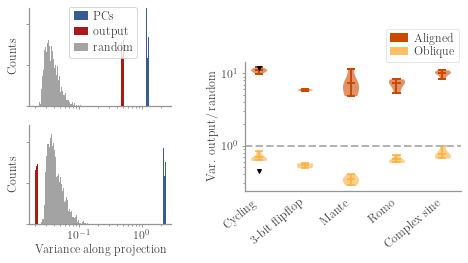

In [8]:
# Join plots
fig = plt.figure(figsize=(6, 3), facecolor='w')
n_rows = n_sce_plt_ex
n_cols_var = 1
gs0 = GridSpec(n_rows, n_cols_var)
gs0.update(left=0.0, right=0.33, bottom=0.0, top=1., wspace=0., hspace=0.2)
axes_var = np.array([[fig.add_subplot(gs0[k, j])
                      for j in range(n_cols_var)] for k in range(n_rows)])
gs0 = GridSpec(1, 1)
gs0.update(left=0.5, right=1., bottom=0.15, top=0.75, wspace=0., hspace=0.2)
ax_bar = fig.add_subplot(gs0[0, 0])

        
#############################################################################
# Variance
plot_var_proj(axes_var)

#############################################################################
# Variance across tasks
dx_fac = 0.
plot_ratio_var(ax_bar)
        
fig_name = "neuro_noise_compression"
saving_fig(fig, figure_path, fig_name, data_type='both')